In [ ]:
!pip install git+https://github.com/albcab/blackjax@svgd;

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax import vmap

import blackjax
from blackjax.vi.svgd import SVGDState, rbf_kernel, update_median_heuristic

In [2]:
def gaussian_mixture(x, mu1=-2, mu2=2):
    pdf = lambda x, mu: jax.scipy.stats.norm.pdf(x, loc=mu, scale=1)
    return (1 / 3) * pdf(x, mu1) + (2 / 3) * pdf(x, mu2)


def gaussian_mixture_log_pdf(x):
    return jnp.log(gaussian_mixture(x))

In [3]:
def svgd_training_loop(
    initial_position,
    log_p,
    kernel,
    *,
    num_iterations=500,
    progress=False,
) -> SVGDState:
    svgd = blackjax.coin_svgd(jax.grad(log_p), kernel)
    state = svgd.init(initial_position)
    state = update_median_heuristic(state)
    step = jax.jit(svgd.step)

    for _ in range(num_iterations):
        state = step(state)
    return state

## The density we are trying to sample from

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


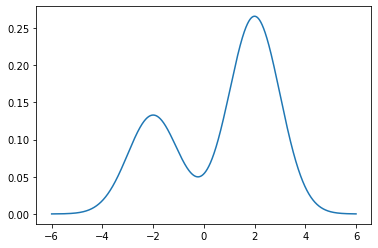

In [4]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-6, 6, 10000)
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax);

In [5]:
num_particles = 100

# Sample initial particles from a (-10, 1) normal distribution
initial_particles = (-10) + jax.random.normal(
    jax.random.PRNGKey(3), shape=(num_particles,)
)

<Axes: ylabel='Density'>

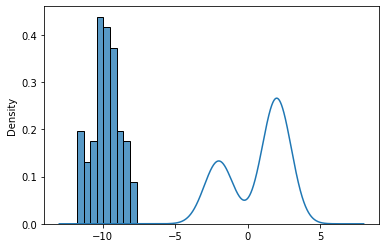

In [6]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-13, 8, 10000)
sns.histplot(initial_particles, ax=ax, stat="density")
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)

In [7]:
# Run the algorithm
out = svgd_training_loop(
    initial_particles,
    log_p=gaussian_mixture_log_pdf,
    kernel=rbf_kernel,
    num_iterations=1000,
    progress=True,
)

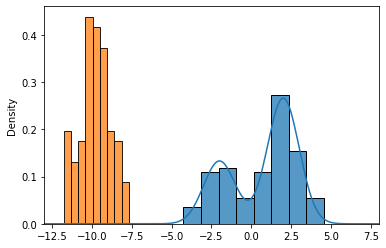

In [8]:
# Plot the results
def plot(particles):
    fig = plt.figure()
    ax = fig.subplots()
    x = jnp.linspace(-13, 8, 10000)
    sns.histplot(particles, ax=ax, stat="density")
    sns.histplot(initial_particles, ax=ax, stat="density")
    sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)
    plt.xlim([-13, 8])
    # plt.show()


plot(out.particles)

In [9]:
print(f"Estimated expectation: {out.particles.mean()}")
print(f"True expectation: {2/3}")

Estimated expectation: 0.6590781211853027
True expectation: 0.6666666666666666
